# Monte Carlo

In [44]:
import gymnasium as gym
from collections import defaultdict

env = gym.make("Blackjack-v1", render_mode="rgb_array")
gamma = 0.01
episodes = 1_000_000

returns_sum = defaultdict(float)
returns_count = defaultdict(int)

V = defaultdict(float)

for _ in(range(episodes)):
    episode = []
    observation, info = env.reset()
    done = False
    
    while not done:
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        episode.append((observation, action, reward))
        observation = next_observation

        done = terminated or truncated

    G = 0
    for i in reversed(range(len(episode))):
        state, action, reward = episode[i]
        G = gamma * G + reward

        if state not in [x[0] for x in episode[:i]]:
            returns_sum[state] += G
            returns_count[state] += 1
            V[state] = returns_sum[state] / returns_count[state] 

env.close()

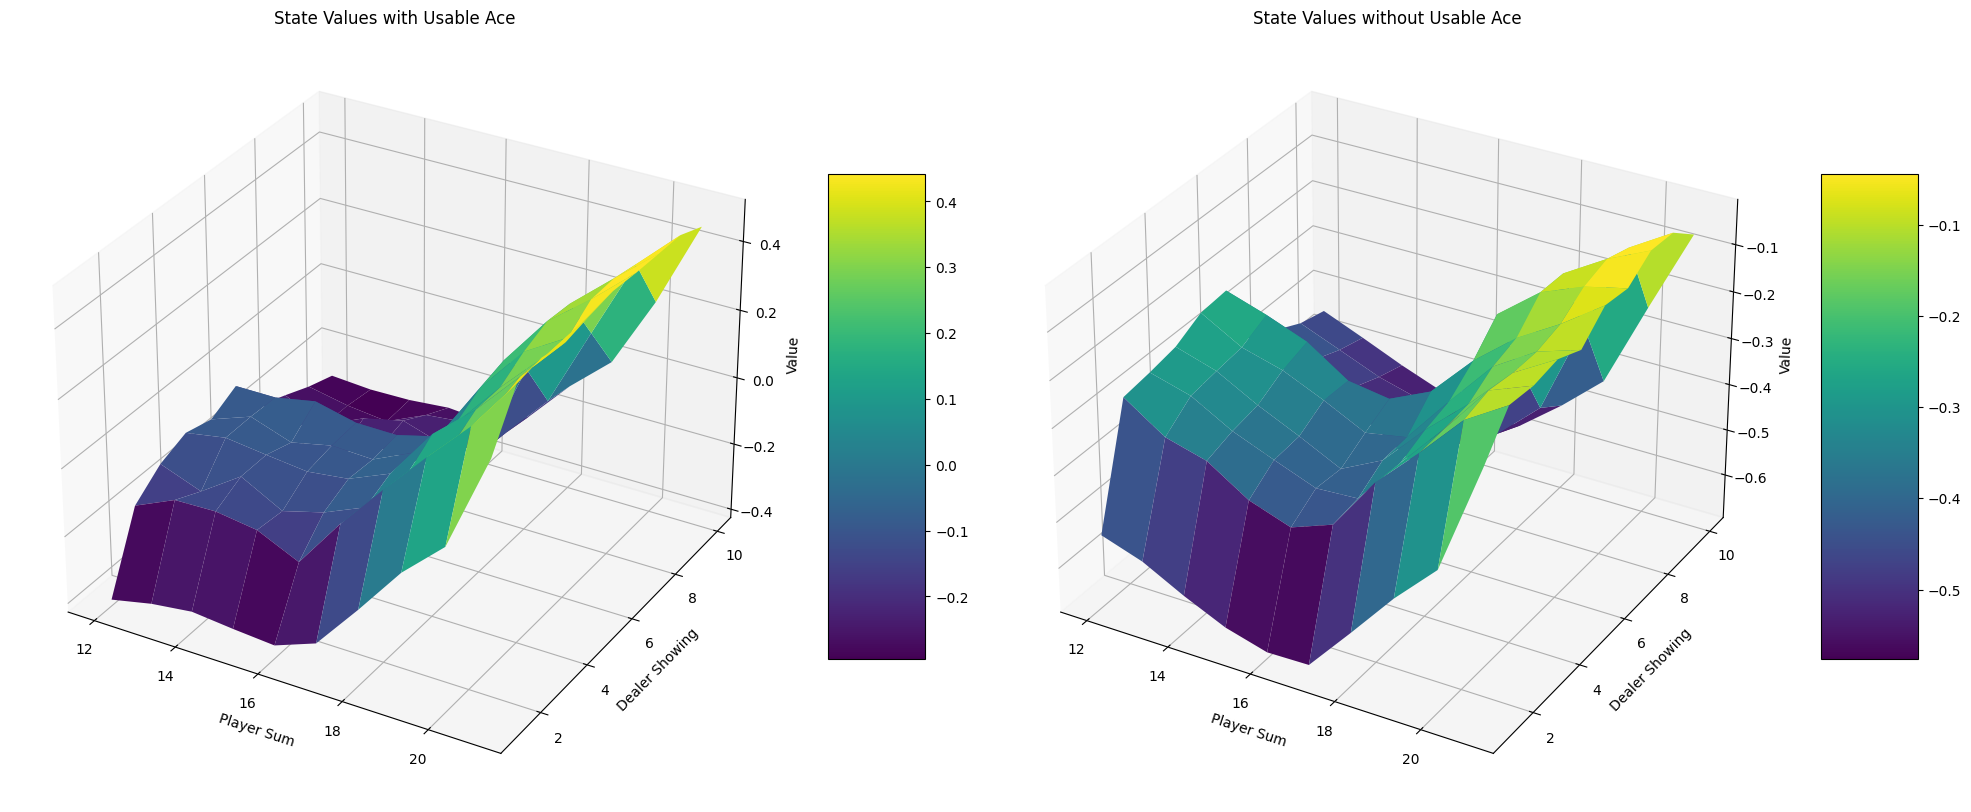

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

player_sum = np.arange(12, 22)
dealer_card = np.arange(1, 11)
X, Y = np.meshgrid(player_sum, dealer_card)

Z_usable_ace = np.zeros((10, 10))
Z_no_usable_ace = np.zeros((10, 10))

for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_card):
        Z_usable_ace[j, i] = V[(player, dealer, True)]
        Z_no_usable_ace[j, i] = V[(player, dealer, False)]

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_usable_ace, cmap='viridis')
ax1.set_xlabel('Player Sum')
ax1.set_ylabel('Dealer Showing')
ax1.set_zlabel('Value')
ax1.set_title("State Values with Usable Ace")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_no_usable_ace, cmap='viridis')
ax2.set_xlabel('Player Sum')
ax2.set_ylabel('Dealer Showing')
ax2.set_zlabel('Value')
ax2.set_title("State Values without Usable Ace")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

# TD

In [46]:
import gymnasium as gym
from collections import defaultdict

env = gym.make("Blackjack-v1", render_mode="rgb_array")
gamma = 0.01
episodes = 1_000_000
lr = 0.01
V = defaultdict(float)

for _ in(range(episodes)):
    episode = []
    observation, info = env.reset()
    done = False
    
    while not done:
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        episode.append((observation, action, reward))
        observation = next_observation
        
        current_v = V[observation]
        next_v = V[next_observation]

        V[observation] = current_v + lr * (reward + gamma * next_v - current_v)

        observation = next_observation
        done = terminated or truncated


env.close()

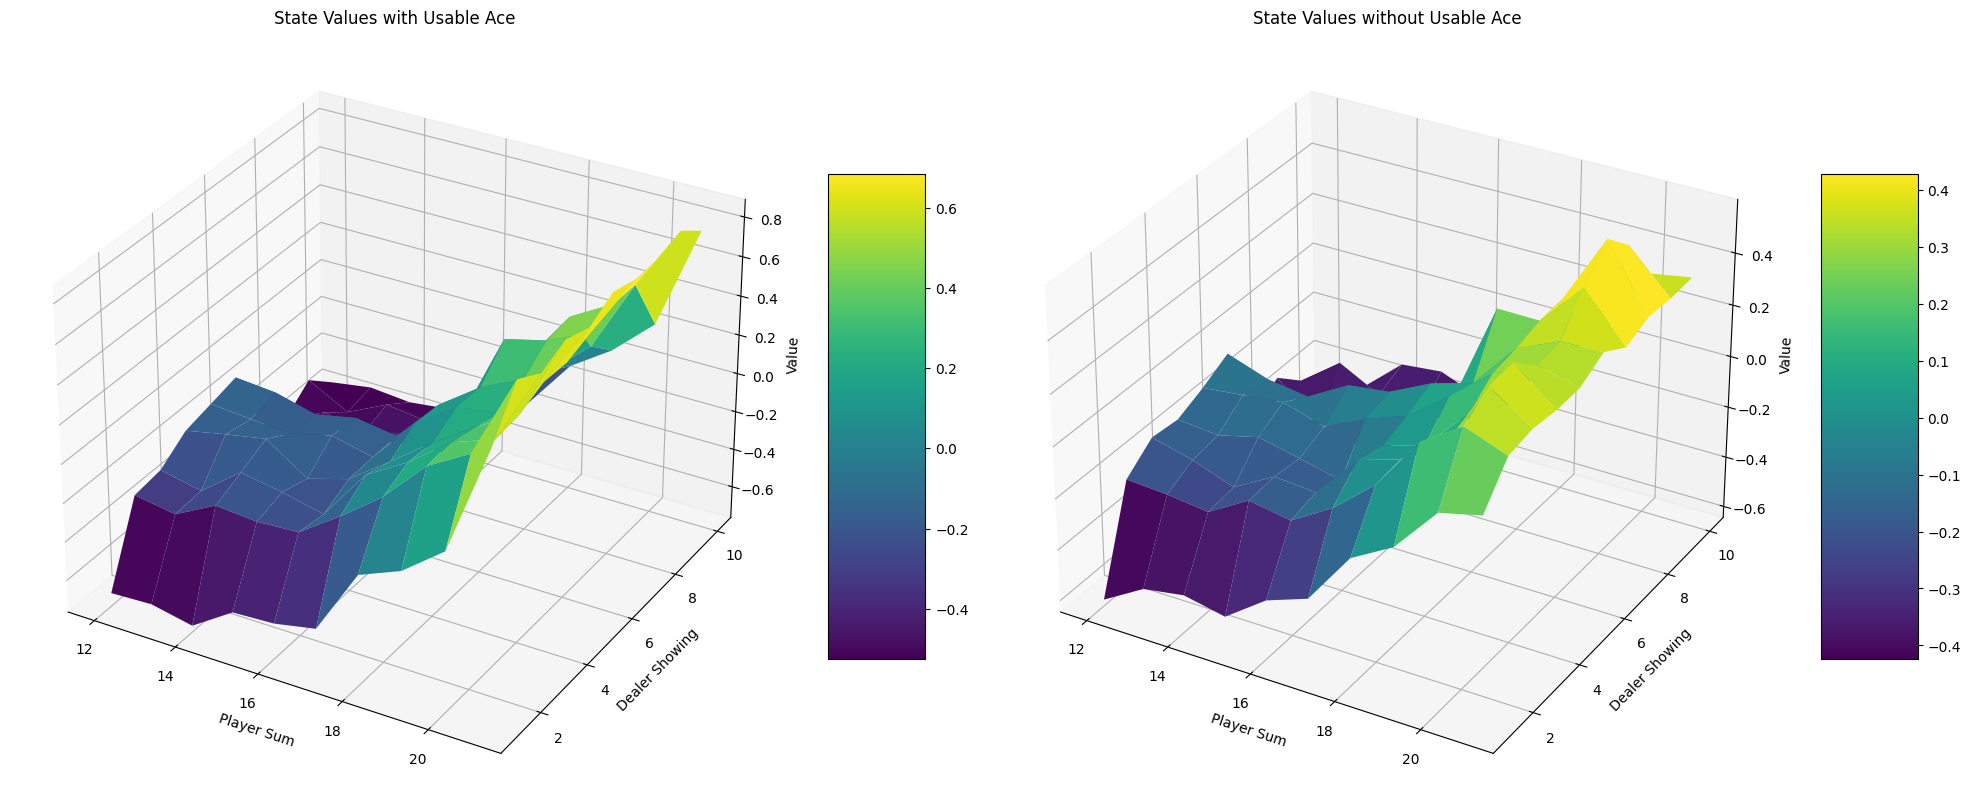

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

player_sum = np.arange(12, 22)
dealer_card = np.arange(1, 11)
X, Y = np.meshgrid(player_sum, dealer_card)

Z_usable_ace = np.zeros((10, 10))
Z_no_usable_ace = np.zeros((10, 10))

for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_card):
        Z_usable_ace[j, i] = V[(player, dealer, True)]
        Z_no_usable_ace[j, i] = V[(player, dealer, False)]

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_usable_ace, cmap='viridis')
ax1.set_xlabel('Player Sum')
ax1.set_ylabel('Dealer Showing')
ax1.set_zlabel('Value')
ax1.set_title("State Values with Usable Ace")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_no_usable_ace, cmap='viridis')
ax2.set_xlabel('Player Sum')
ax2.set_ylabel('Dealer Showing')
ax2.set_zlabel('Value')
ax2.set_title("State Values without Usable Ace")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

# Q Learning

In [57]:
import gymnasium as gym
from collections import defaultdict
import numpy as np

env = gym.make("Blackjack-v1", render_mode="rgb_array")
gamma = 0.99  
alpha = 0.1  
episodes = 1_000_000


Q = defaultdict(lambda: np.zeros(env.action_space.n))

def epsilon_greedy_policy(state, epsilon=0.1):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])
  
for _ in(range(episodes)):
    observation, info = env.reset()
    done = False
    
    while not done:
        action = epsilon_greedy_policy(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        episode.append((observation, action, reward))

        best_next_action = np.argmax(Q[next_observation])
        Q[observation][action] += alpha * (reward + gamma * Q[next_observation][best_next_action] - Q[observation][action])
        
        observation = next_observation
        done = terminated or truncated


env.close()

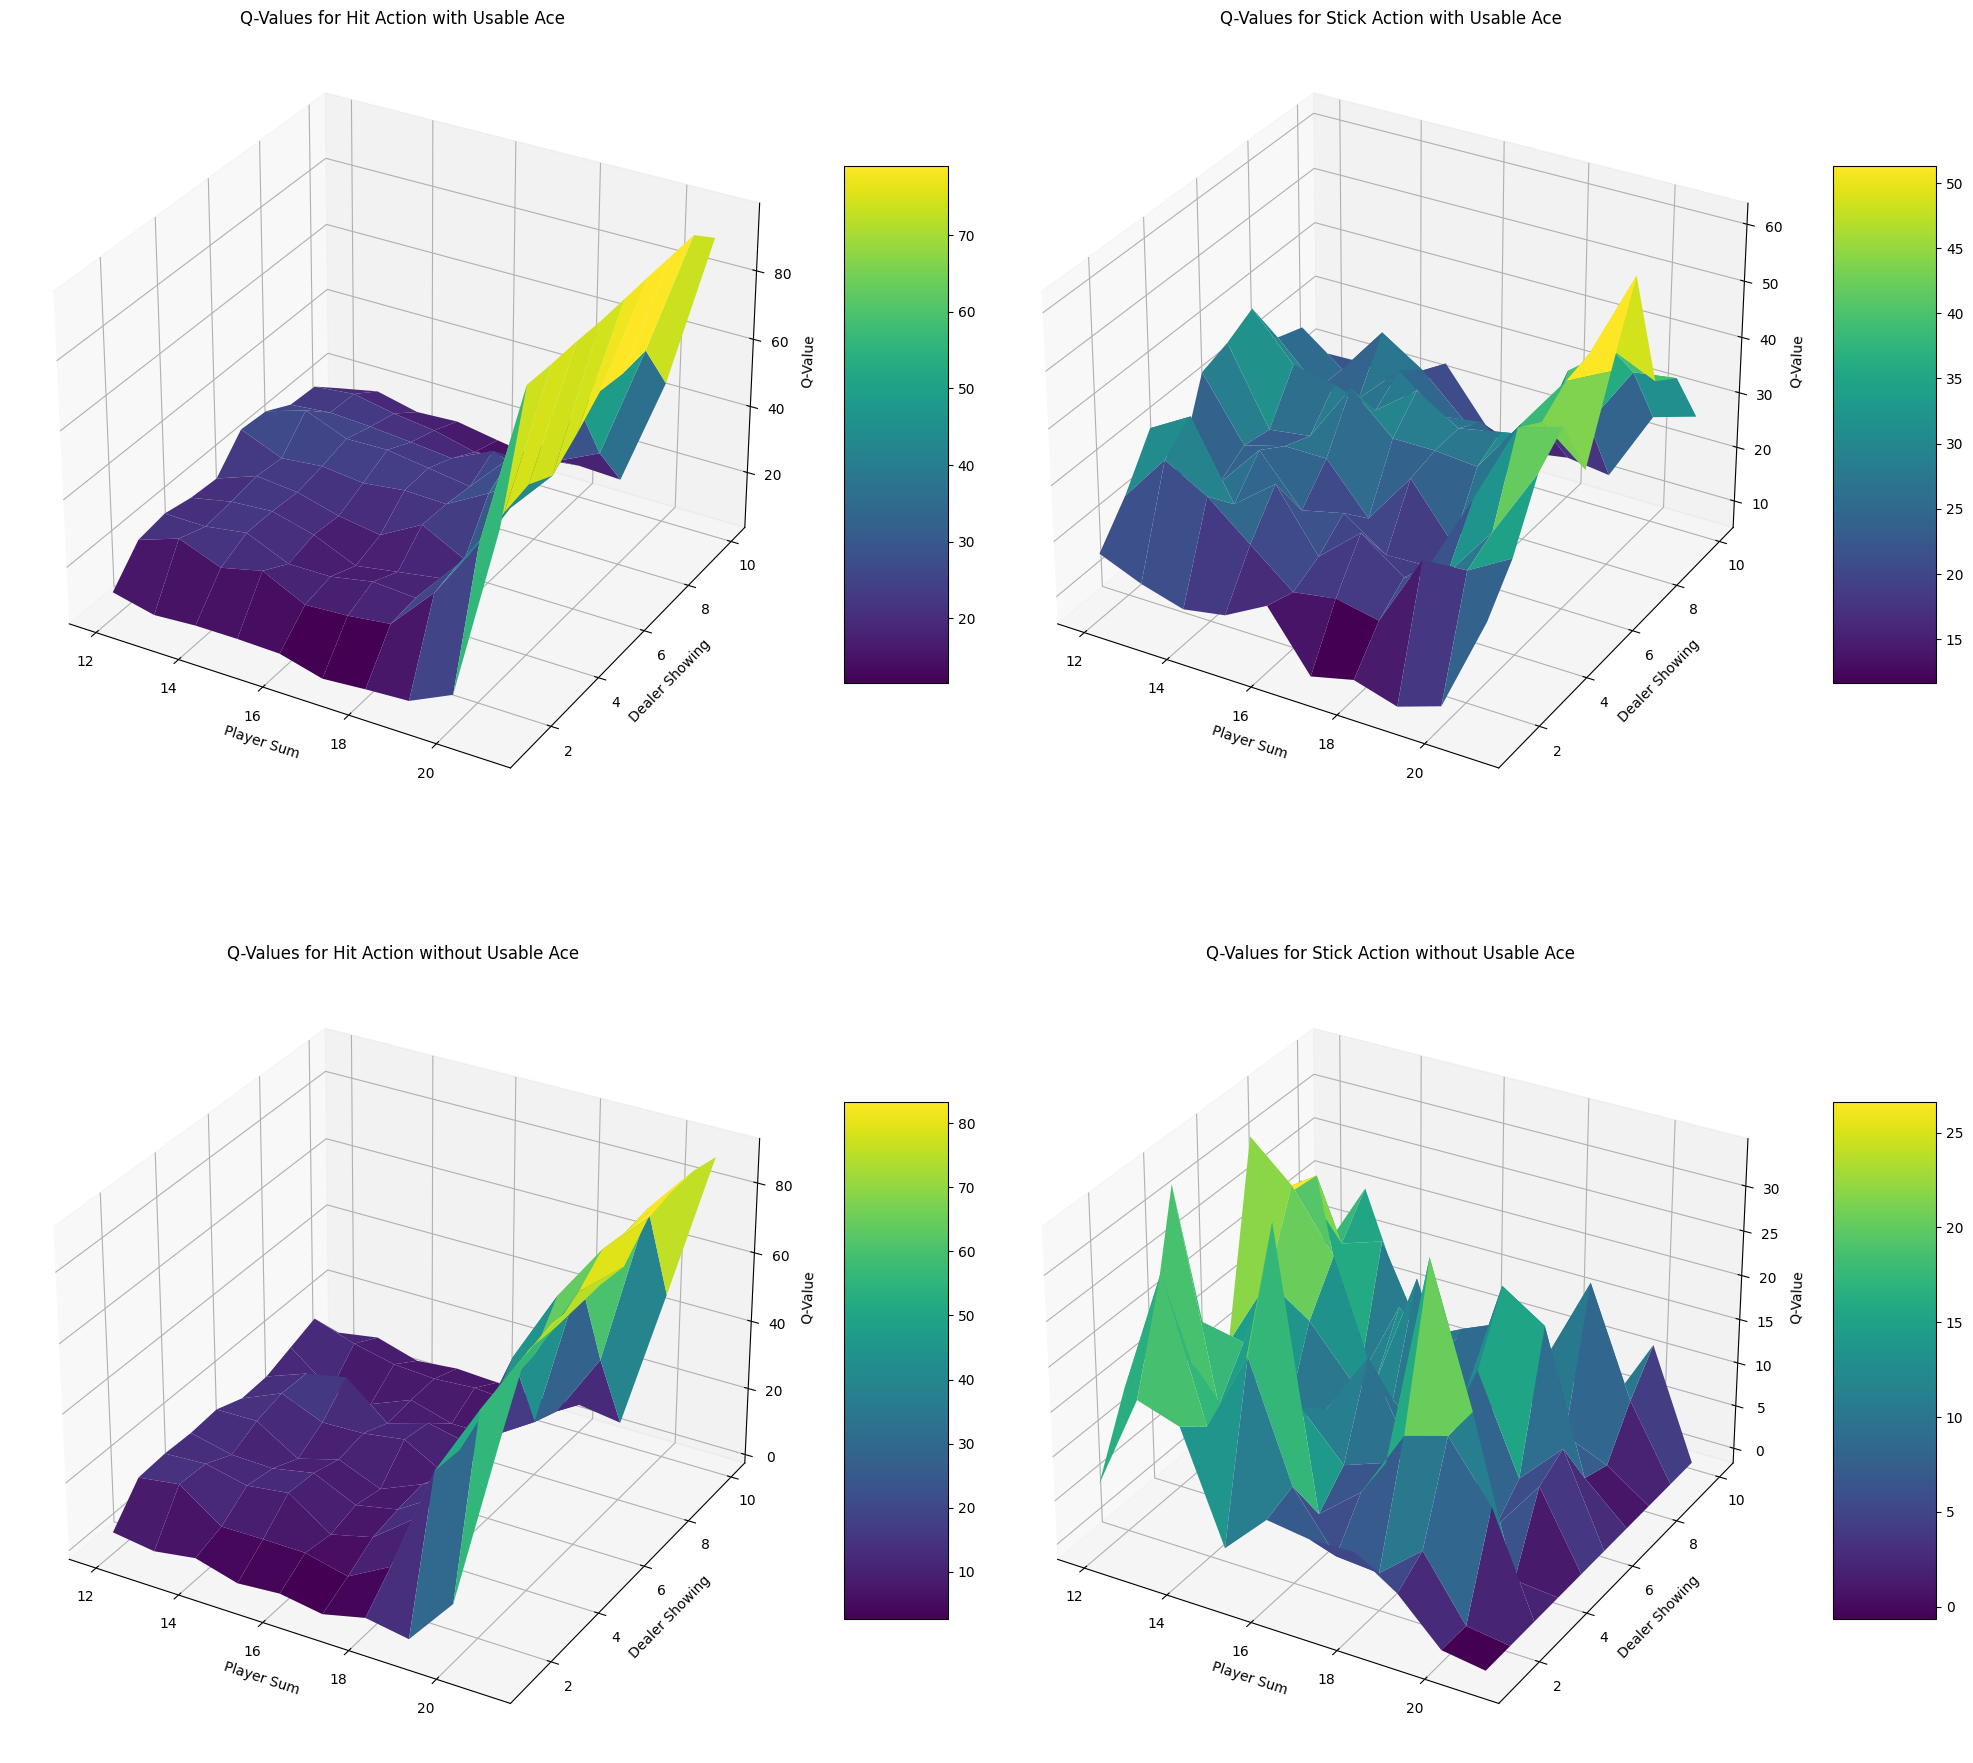

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Prepare the data
player_sum = np.arange(12, 22)
dealer_card = np.arange(1, 11)
X, Y = np.meshgrid(player_sum, dealer_card)

# Create four separate 2D arrays for each scenario
Z_hit_usable_ace = np.zeros((10, 10))
Z_stick_usable_ace = np.zeros((10, 10))
Z_hit_no_usable_ace = np.zeros((10, 10))
Z_stick_no_usable_ace = np.zeros((10, 10))

for i, player in enumerate(player_sum):
    for j, dealer in enumerate(dealer_card):
        Z_hit_usable_ace[j, i] = Q[(player, dealer, True)][0]  # 0 is the "hit" action
        Z_stick_usable_ace[j, i] = Q[(player, dealer, True)][1]  # 1 is the "stick" action
        Z_hit_no_usable_ace[j, i] = Q[(player, dealer, False)][0]
        Z_stick_no_usable_ace[j, i] = Q[(player, dealer, False)][1]

# Create the plots
fig = plt.figure(figsize=(20, 20))

# Plot for hit action with usable ace
ax1 = fig.add_subplot(221, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_hit_usable_ace, cmap='viridis')
ax1.set_xlabel('Player Sum')
ax1.set_ylabel('Dealer Showing')
ax1.set_zlabel('Q-Value')
ax1.set_title("Q-Values for Hit Action with Usable Ace")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Plot for stick action with usable ace
ax2 = fig.add_subplot(222, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_stick_usable_ace, cmap='viridis')
ax2.set_xlabel('Player Sum')
ax2.set_ylabel('Dealer Showing')
ax2.set_zlabel('Q-Value')
ax2.set_title("Q-Values for Stick Action with Usable Ace")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

# Plot for hit action without usable ace
ax3 = fig.add_subplot(223, projection='3d')
surf3 = ax3.plot_surface(X, Y, Z_hit_no_usable_ace, cmap='viridis')
ax3.set_xlabel('Player Sum')
ax3.set_ylabel('Dealer Showing')
ax3.set_zlabel('Q-Value')
ax3.set_title("Q-Values for Hit Action without Usable Ace")
fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

# Plot for stick action without usable ace
ax4 = fig.add_subplot(224, projection='3d')
surf4 = ax4.plot_surface(X, Y, Z_stick_no_usable_ace, cmap='viridis')
ax4.set_xlabel('Player Sum')
ax4.set_ylabel('Dealer Showing')
ax4.set_zlabel('Q-Value')
ax4.set_title("Q-Values for Stick Action without Usable Ace")
fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()